# Structure from Motion (SfM)

1. [Extract video frames](#extract-video-frames)
2. [Feature Detection + Extraction: SIFT](#feature-detection--extraction-sift)
3. [Feature matching: BFMatcher - knnMatch](#feature-matching-bfmatcher---knnmatch)

## Extract video frames

In [132]:
import os
import cv2

In [133]:
def save_video_frames(
    video_path: str,
    output_folder: str,
    start_frame: int = 0,
    end_frame: int | None = None,
    interval: int = 10,
) -> None:
    os.makedirs(output_folder, exist_ok=True)

    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()

    if end_frame is None:
        end_frame = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    count = start_frame

    while success and count <= end_frame:
        if count % interval == 0:
            cv2.imwrite(os.path.join(output_folder, f"frame_{count}.jpg"), image)
        success, image = vidcap.read()
        count += 1

    vidcap.release()
    cv2.destroyAllWindows()

In [ ]:
save_video_frames(video_path='data/200S0264.mp4', output_folder='data/frames', start_frame=0, end_frame=10000, interval=10)

## Feature Detection + Extraction: SIFT

In [152]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from typing import Sequence
from cv2 import DMatch, KeyPoint
from cv2.typing import MatLike

In [153]:
def extract_features_sift(image: MatLike) -> tuple[Sequence[KeyPoint], np.ndarray]:
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    print(f"Number of keypoints: {len(keypoints)}")
    print(f"Descriptors shape: {descriptors.shape}")
    return keypoints, descriptors

In [154]:
def visualize_features(image: MatLike, keypoints: list, output_path: str) -> None:
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
        
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    cv2.imwrite(output_path, image_with_keypoints)

In [155]:
frame_2600 = cv2.imread("data/frames/frame_2600.jpg", cv2.IMREAD_GRAYSCALE)
frame_2610 = cv2.imread("data/frames/frame_2610.jpg", cv2.IMREAD_GRAYSCALE)

keypoints_frame_2600, descriptors_frame_2600 = extract_features_sift(image=frame_2600)
visualize_features(
    image=frame_2600,
    keypoints=keypoints_frame_2600,
    output_path="data/frame_keypoints/frame_2600.jpg",
)

keypoints_frame_2610, descriptors_frame_2610 = extract_features_sift(image=frame_2610)
visualize_features(
    image=frame_2610,
    keypoints=keypoints_frame_2610,
    output_path="data/frame_keypoints/frame_2610.jpg",
)

Number of keypoints: 819
Descriptors shape: (819, 128)
Number of keypoints: 503
Descriptors shape: (503, 128)


## Feature matching: BFMatcher - knnMatch

In [156]:
def match_features(descriptors_frame_1, descriptors_frame_2) -> list[DMatch]:
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_frame_1, descriptors_frame_2, k=2)

    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return good_matches

In [157]:
def visualize_matches(
    frame_1: MatLike,
    frame_2: MatLike,
    keypoints_frame_1: Sequence[KeyPoint],
    keypoints_frame_2: Sequence[KeyPoint],
    matches: list[DMatch],
    output_path: str,
) -> None:    
    img_matches = cv2.drawMatches(frame_1, keypoints_frame_1, frame_2, keypoints_frame_2, matches, None)
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

    plt.imsave(output_path, img_matches_rgb)

    plt.figure(dpi=300)
    plt.imshow(img_matches_rgb)
    plt.axis("off")
    plt.show()

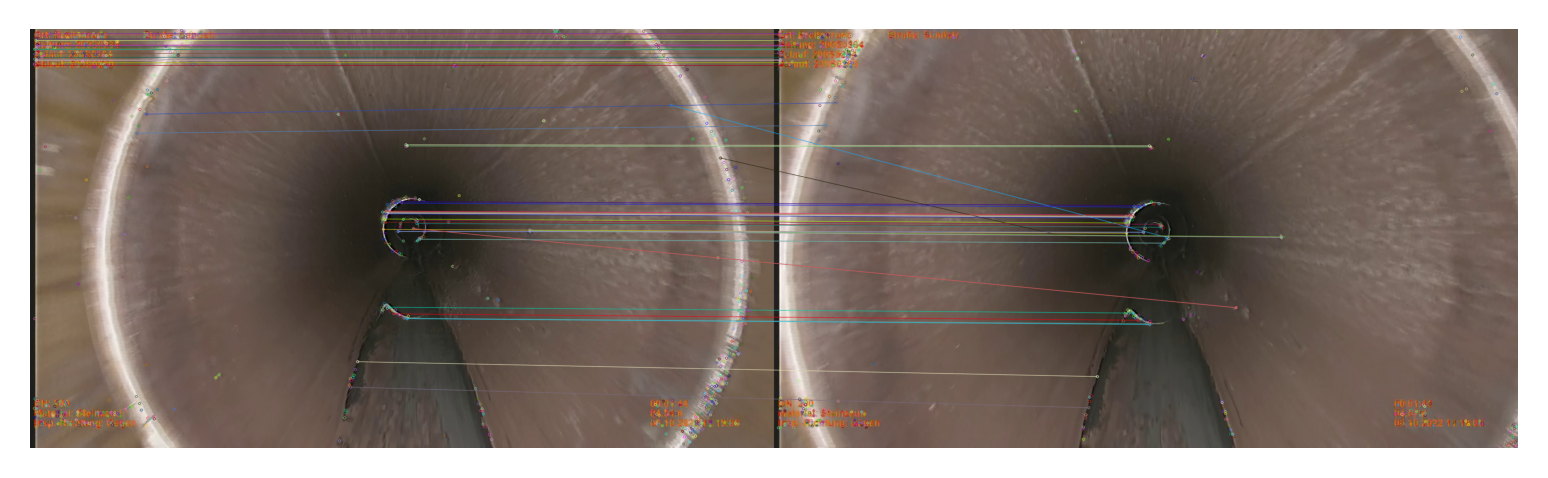

In [158]:
feature_matches = match_features(descriptors_frame_2600, descriptors_frame_2610)

visualize_matches(
    cv2.imread("data/frames/frame_2600.jpg"),
    cv2.imread("data/frames/frame_2610.jpg"),
    keypoints_frame_2600,
    keypoints_frame_2610,
    matches=sorted(feature_matches, key=lambda x: x.distance)[:50],
    output_path="data/frame_matches/frames_2600_2610.jpg",
)